In [1]:
import utils

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import lutorpy as lua
require("nn")
require("optim")
require("cutorch")
require("cunn")

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [9]:
train_data, train_results, test_data, test_results = utils.read_data()

In [60]:
# for transfer function you could use some of these: https://github.com/torch/nn/blob/master/doc/transfer.md

def mult_layers_nn(train_data, train_results, test_data, hidden_nodes_num, learning_rate, epoch_num):
    train_data_model = to_model_with_features(train_data)
    train_results_model = to_model(make_delta(train_data, train_results))
    test_data_model = to_model_with_features(test_data)
    
    ninputs = to_model_with_features(test_data).shape[1]
    noutputs = 10
    
    # define model (predictor): 
    transfer_function=nn.Tanh()    
    mlp = nn.Sequential()
    mlp._add(nn.Linear(ninputs, hidden_nodes_num)) 
    mlp._add(transfer_function)
    mlp._add(nn.Linear(hidden_nodes_num, hidden_nodes_num))
    mlp._add(transfer_function)
    mlp._add(nn.Linear(hidden_nodes_num, hidden_nodes_num))
    mlp._add(transfer_function)
    mlp._add(nn.Linear(hidden_nodes_num, hidden_nodes_num))
    mlp._add(transfer_function)
    mlp._add(nn.Linear(hidden_nodes_num, noutputs))
    mlp._cuda()

    # define a loss function to be minimized (mean-square error between predictions and groundtruth labels)
    criterion = nn.MSECriterion() 
    criterion._cuda()
    
    crit_change = []
    
    for epoch in range(epoch_num):
        # get sample
        inputs = (torch.fromNumpyArray(train_data_model.astype(float)))._cuda()
        outputs = (torch.fromNumpyArray(train_results_model.astype(float)))._cuda()

        # feed it to the neural network and the criterion
        crit_change.append(criterion._forward(mlp._forward(inputs), outputs))

        # train over this example in 3 steps
        # (1) zero the accumulation of the gradients
        mlp._zeroGradParameters()
        # (2) accumulate gradients
        mlp._backward(inputs, criterion.backward(criterion, mlp.output, outputs))

        # (3) update parameters with a learning rate
        mlp._updateParameters(learning_rate)
        
    result = (mlp._forward((torch.fromNumpyArray(test_data_model.astype(float)))._cuda())).asNumpyArray()
    
    crit_change = np.array(crit_change)
    #print(crit_change[::int(epoch_num / 10)])
        
    return unmake_delta(test_data, from_model(result))

1/3: 2016-12-01 15:40:50
2/3: 2016-12-01 15:43:27
3/3: 2016-12-01 15:46:36
done! 2016-12-01 15:51:38
Results: [-5.4845269328331163, -4.5186997753415614, -4.1439541247762568]


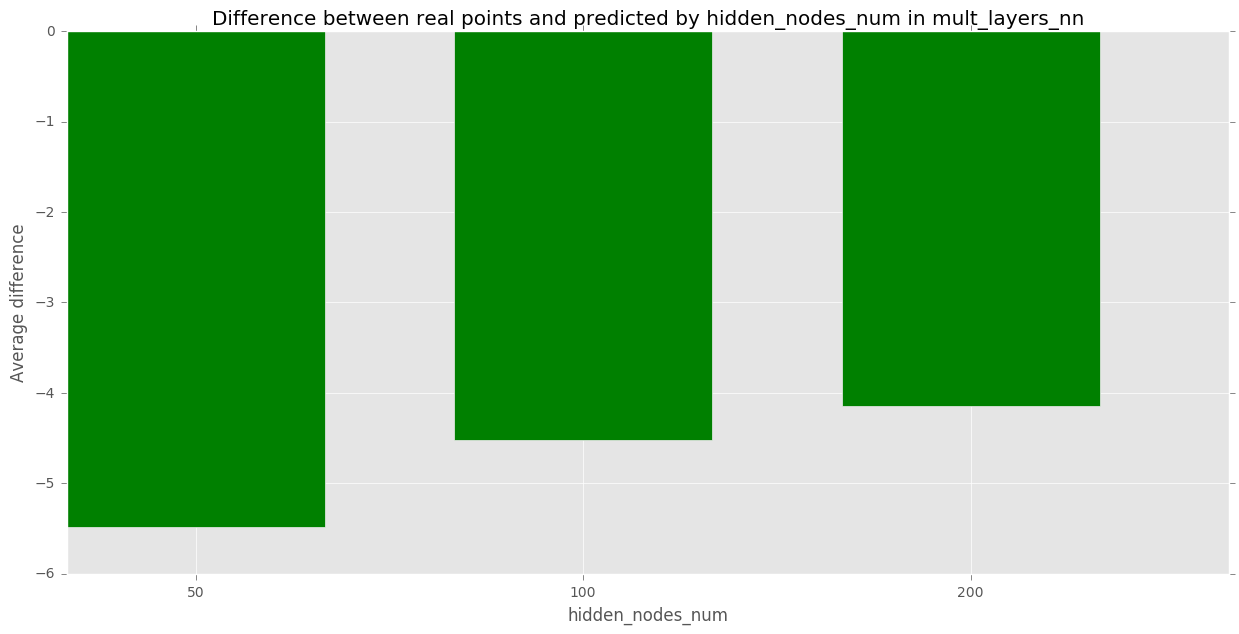

In [61]:
compare_results(function=mult_layers_nn, test_results=train_results, parameter_name="hidden_nodes_num",
                list_of_values=[50, 100, 200], train_data=train_data, train_results=train_results,
                test_data=train_data, learning_rate=0.01, epoch_num=1000)

1/3: 2016-12-01 15:51:39
2/3: 2016-12-01 15:54:17
3/3: 2016-12-01 15:57:24
done! 2016-12-01 16:02:20
Results: [-5.2771559179767911, -5.1448566044840733, -4.2794359346151865]


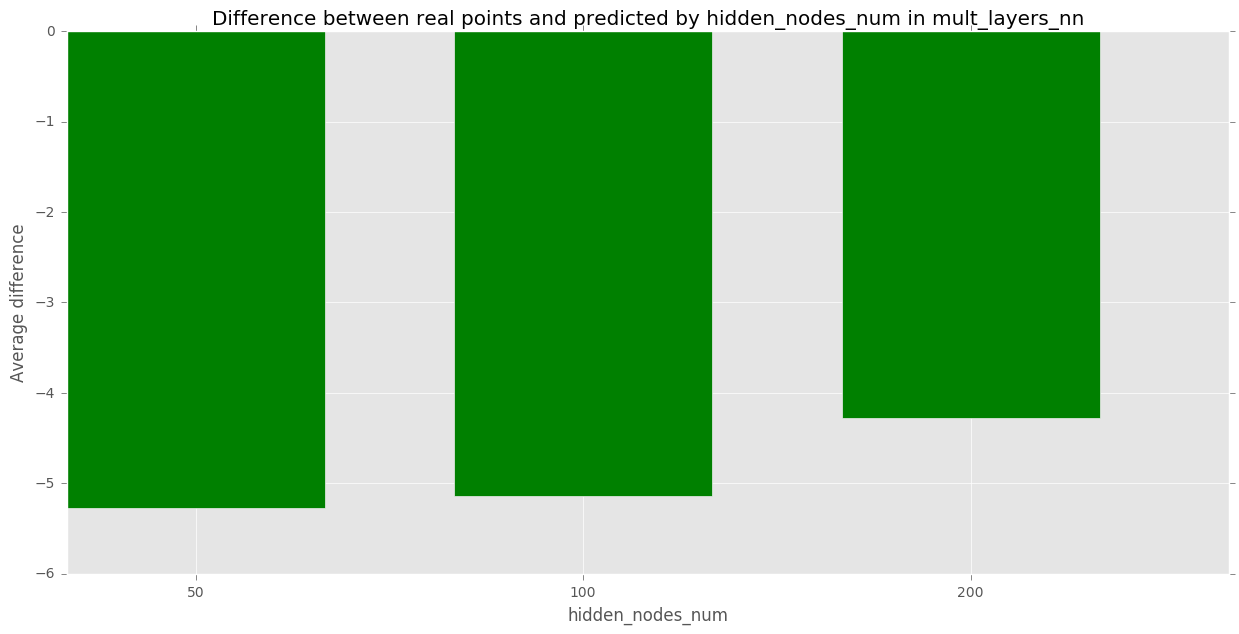

In [62]:
compare_results(function=mult_layers_nn, test_results=test_results, parameter_name="hidden_nodes_num",
                list_of_values=[50, 100, 200], train_data=train_data, train_results=train_results,
                test_data=test_data, learning_rate=0.01, epoch_num=1000)